In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import torch

In [2]:
import scipy.optimize

In [129]:
gamma = torch.tensor(5.)
m = torch.tensor(1.)
T = torch.tensor(1.)
dt = torch.tensor(0.001)

X = torch.zeros(1000000)
for i in range(1,1000000):

    X[i] = X[i-1] - gamma*X[i-1]*dt + torch.sqrt(torch.tensor(dt*T*2*gamma/m))*torch.randn((1))[0]

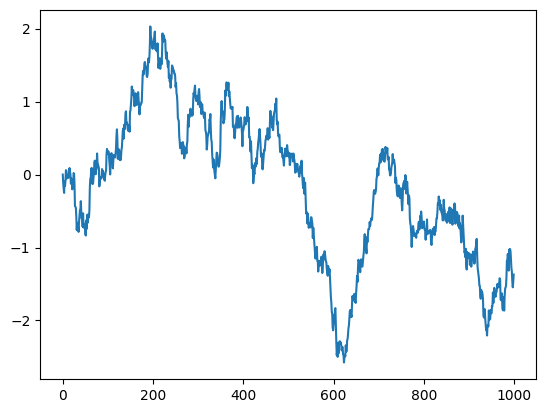

In [132]:
plt.plot(X[:1000])

In [140]:
autocorrs = torch.zeros(10000)
for i in range(10000):
    autocorrs[i] = torch.mean(X[:(X.shape[0]-i)] * X[i:]) 

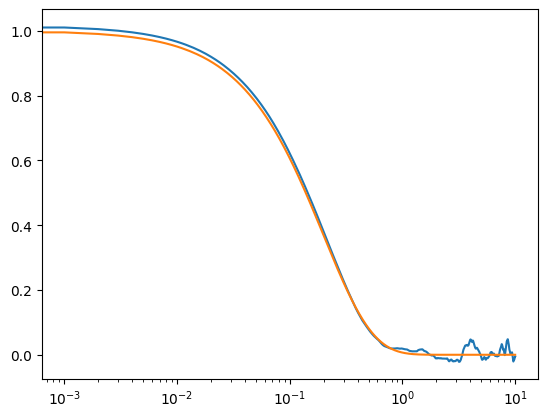

In [150]:
plt.plot(np.arange(10000)*0.001,autocorrs)
plt.plot(np.arange(10000)*0.001,np.exp(-5*np.arange(10000)*0.001))

plt.xscale('log')

In [401]:
a = torch.tensor(1., requires_grad = True)
k = torch.tensor(0., requires_grad = True)
SigmaXt = torch.tensor(T/m)
sigmaXt_prior = SigmaXt.clone()
delta_t = torch.tensor(0.04)

H = torch.exp(-gamma * delta_t)

delta_L = 10
previous_L = 0
epoch = 0
beta = 1.1

step_size = 0.001
max_epochs = 10000


posterior_info = torch.zeros(max_epochs)
obs_info = torch.zeros(max_epochs)
losses = torch.zeros(max_epochs)

while abs(delta_L)>0.00001:
    if epoch%50==0:
        SigmaXt_prior = SigmaXt.clone()
        print(delta_L)
    first_term = (1 - k*a) * sigmaXt_prior * (1-k*a)
    second_term = k ** 2
    
    sigmaXt_posterior = first_term + second_term

    sigma_Obs = a*SigmaXt*a + 1
    L = torch.log(sigmaXt_posterior) + beta * torch.log(sigma_Obs)

    delta_L = L - previous_L
    previous_L = L
    sigmaXt_prior = H * sigmaXt_posterior * H + (1 - H**2)

    posterior_info[epoch] = - torch.log(sigmaXt_posterior)
    obs_info[epoch] = torch.log(sigma_Obs)
    
    L.backward(retain_graph=True)

    k.data -= step_size * k.grad.data

    
    a.data -= step_size * a.grad.data

    k.grad.zero_()
    a.grad.zero_()

    losses[epoch] = L.item()
    epoch+=1


10
tensor(-0.0066, grad_fn=<SubBackward0>)
tensor(-0.0014, grad_fn=<SubBackward0>)
tensor(-0.0003, grad_fn=<SubBackward0>)
tensor(-9.8884e-05, grad_fn=<SubBackward0>)
tensor(-3.3319e-05, grad_fn=<SubBackward0>)
tensor(-1.3888e-05, grad_fn=<SubBackward0>)


In [402]:
sigmaXt_prior

tensor(0.5898, grad_fn=<AddBackward0>)

In [403]:
sigmaXt_posterior

tensor(0.3880, grad_fn=<AddBackward0>)

In [404]:
sigmaxt_giv_zt = 1 - a**2 / sigma_Obs

In [413]:
z = a*X + torch.randn_like(X)

In [414]:
x_giv_z = a/(a**2 + 1) * z

In [415]:
x_giv_z

tensor([-0.1303,  0.8204, -0.1843,  ...,  0.8081,  0.1667, -0.2700],
       grad_fn=<MulBackward0>)

In [416]:
x_posterior = torch.zeros(X.shape[0]//40)

In [417]:
for i in range(1, x_posterior.shape[0]):
    x_posterior[i] = x_posterior[i-1]*H + k * (a*X[40*i-1] + torch.randn((1,)) - a*H*x_posterior[i-1])

In [418]:
x_prior = torch.zeros_like(x_posterior)

In [419]:
for i in range(1, x_posterior.shape[0]):
    x_prior[i] = H*x_posterior[i-1]

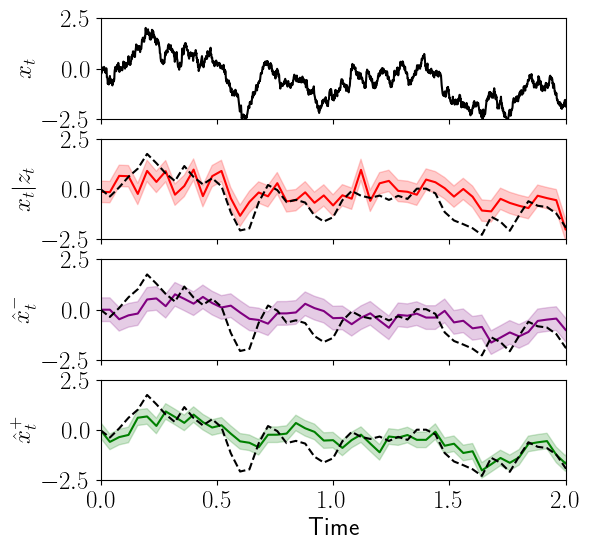

In [429]:
ts = np.arange(10000)*0.001
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(4,1, sharex = True, sharey = True)
fig.set_size_inches(6,6)
axs[0].set_xlim(0,10)
axs[0].set_ylabel('$x_{t}$', fontsize=18)
axs[1].set_ylabel('$x_{t}|z_{t}$', fontsize=18)
axs[2].set_ylabel('$\hat{x}_{t}^{-}$', fontsize=18)
axs[3].set_ylabel('$\hat{x}_{t}^{+}$', fontsize=18)
axs[0].tick_params(axis='both', labelsize=18)
axs[1].tick_params(axis='both', labelsize=18)
axs[2].tick_params(axis='both', labelsize=18)
axs[3].tick_params(axis='both', labelsize=18)

axs[3].set_xlabel('Time', fontsize=18)
axs[0].plot(ts, X[:10000], color = 'black')
axs[1].plot(ts[0:10000:40], x_giv_z.detach().numpy()[0:10000:40], color = 'red')
axs[1].fill_between(ts[0:10000:40], x_giv_z.detach().numpy()[0:10000:40]-sigmaxt_giv_zt.detach().numpy(), x_giv_z.detach().numpy()[0:10000:40]+sigmaxt_giv_zt.detach().numpy(), color='red', alpha=0.2) 
axs[2].plot(ts[0:10000:40], x_prior.detach().numpy()[:250], color = 'purple')
axs[2].fill_between(ts[0:10000:40], x_prior.detach().numpy()[:250]-sigmaXt_prior.detach().numpy(), x_prior.detach().numpy()[:250]+sigmaXt_prior.detach().numpy(), color='purple', alpha=0.2) 
axs[3].plot(ts[0:10000:40], x_posterior.detach().numpy()[:250], color = 'green')
axs[3].fill_between(ts[0:10000:40], x_posterior.detach().numpy()[:250]-sigmaXt_posterior.detach().numpy(), x_posterior.detach().numpy()[:250]+sigmaXt_posterior.detach().numpy(), color='green', alpha=0.2) 
axs[3].plot(ts[0:10000:40], X[0:10000:40], color = 'black', ls='--')
axs[2].plot(ts[0:10000:40], X[0:10000:40], color = 'black', ls='--')
axs[1].plot(ts[0:10000:40], X[0:10000:40], color = 'black', ls='--')
#axs[3].plot(ts[0:10000:40], x_prior.detach().numpy()[:250], color = 'purple', ls='--')
axs[0].set_ylim((-2.5,2.5))
axs[0].set_xlim((0,2))

plt.savefig('1d_trace.pdf', bbox_inches='tight')

In [344]:
betas = np.arange(1.001,1.01,0.001)
#betas_2 = np.arange(1.1,5,0.1)
#betas = np.asarray(list(betas_1)+list(betas_2))
#end_post = []
#end_obs = []
for index, beta in tqdm(enumerate(betas)):
    a = torch.tensor(1., requires_grad = True)
    k = torch.tensor(0., requires_grad = True)
    SigmaXt = torch.tensor(T/m)
    sigmaXt_prior = SigmaXt.clone()
    delta_t = torch.tensor(0.04)
    
    H = torch.exp(-gamma * delta_t)
    
    delta_L = 10
    previous_L = 0
    epoch = 0
    
    step_size = 0.001
    max_epochs = 10000
    
    
    posterior_info = torch.zeros(max_epochs)
    obs_info = torch.zeros(max_epochs)
    losses = torch.zeros(max_epochs)
    
    while abs(delta_L)>0.00001:
        if epoch%50==0:
            SigmaXt_prior = SigmaXt.clone()
            #print(delta_L)
        first_term = (1 - k*a) * sigmaXt_prior * (1-k*a)
        second_term = k ** 2
        
        sigmaXt_posterior = first_term + second_term
    
        sigma_Obs = a*SigmaXt*a + 1
        L = torch.log(sigmaXt_posterior) + beta * torch.log(sigma_Obs)
    
        delta_L = L - previous_L
        previous_L = L
        sigmaXt_prior = H * sigmaXt_posterior * H + (1 - H**2)
    
        posterior_info[epoch] = - torch.log(sigmaXt_posterior)
        obs_info[epoch] = torch.log(sigma_Obs)
        
        L.backward(retain_graph=True)
    
        k.data -= step_size * k.grad.data
    
        
        a.data -= step_size * a.grad.data
    
        k.grad.zero_()
        a.grad.zero_()
    
        losses[epoch] = L.item()
        epoch+=1
    
    end_post.append(posterior_info[epoch-1])
    end_obs.append(obs_info[epoch-1])

10it [00:08,  1.12it/s]


In [338]:
delta_L

tensor(-1.6272e-05, grad_fn=<SubBackward0>)

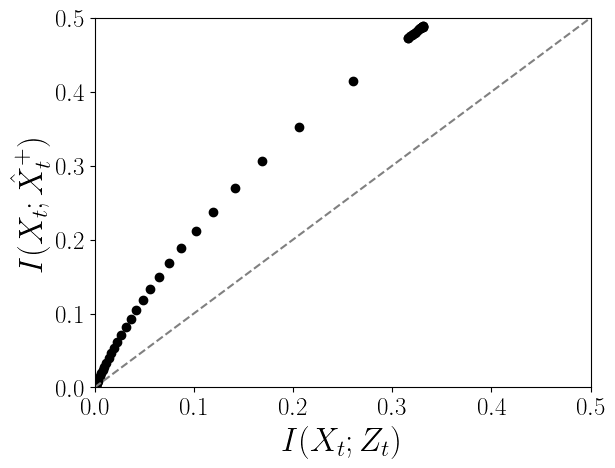

In [438]:
plt.scatter([1/2*info.detach().numpy() for info in end_obs], [1/2 * torch.log(SigmaXt)+1/2*info.detach().numpy() for info in end_post], color = 'black')
plt.plot([0,5],[0,5], color='grey', ls='--')
#plt.colorbar()
plt.xlim((0,0.5))
plt.ylim((0,0.5))
#plt.savefig('info_plane.pdf', bbox_inches='tight')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('$I(X_{t};Z_{t})$', fontsize=24)
plt.ylabel('$I(X_{t};\hat{X}_{t}^{+})$', fontsize=24)
plt.savefig('1d_info_plane.pdf', bbox_inches='tight')

In [346]:
a

tensor(0.9665, requires_grad=True)

In [387]:
1-H**2

tensor(0.3297)